![alt text](https://1.bp.blogspot.com/-abb3H5nTW7A/VXOT5Js2DeI/AAAAAAAAuE4/-D4TlMMPsX4/s600/machi_line2.png)

# The Battle of Neighborhoods - A Relocation Problem

--------------

**NOTE: If you can't see the map, that's because GitHub is disabling the JavaScript on the rendering of notebooks
Please use https://nbviewer.jupyter.org/ to render the Jupyter Notebook**

## Summary

In this report, we use location data acquired from Foursquare API to compare some of the populous cities in the United States in order to narrow down the list of cities for relocation from the current city of residence.
We use K-means clustering to group similar cities together and discover underlying patterns. As a result, we were able to determine which cities are desireable if we were to move from the current place.

## Section 1. Background and Problem
-----------------

### Business Problem - I love this city, BUT

Let me begin by introducing myself a little bit. 
We moved from another country 5 years ago and started living near the "Silicon Valley", California, U.S.A.
We love everything about the area, especially the cultural diversity!
Everyone is so different and we love the fact that being different is okay, actually it is what makes everyone so unique. 

However, the real estate issue here is a disaster. Who knew this is place has the highest median rent in the country?
If we could live in a similar city in the States with similar multi-cultural environment, where would that be?
Is it New York? Is it Portland? Is it Seattle? Or even Austin? 
How are they similar or different from the current city we live in?

### Target Audience

The target audience is someone like us, an immigrant who has little or no knowledge about the differences or similarities between the major cities in the United States. 
By grouping the similar cities together by K-means clustering, we can have some kind of idea where we want to move to if we wanted to.

In addition, the clustered result may benefit real estate companies to invest in cities where it shares the similar characteristic to City A and suggest a similar City B to people who wants to relocate like us.


## Section 2. Data
----------------------------

Three types of data will be used to solve the problem: List of cities in the U.S., FourSquare location data, and the median rent data. 

### A) List of United States cities by population

The below link has a table of 314 populous cities in the States. 

https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

website_text = requests.get('https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population').text
soup = BeautifulSoup(website_text,'xml')

table = soup.find('table',{'class':'wikitable sortable'}) 
table_rows = table.find_all('tr')

data = []
for row in table_rows:
    data.append([t.text.strip() for t in row.find_all('td')])

df = pd.DataFrame(data, columns=['2018 Rank', 'City', 'State', '2018 estimate', '2010 Census', 'Change', '2016 land area mile','2016 land area km', '2016 population density mi','2016 population density km', 'location'])
df.drop(df.index[0], inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,2018 Rank,City,State,2018 estimate,2010 Census,Change,2016 land area mile,2016 land area km,2016 population density mi,2016 population density km,location
0,1,New York[d],New York,"8,398,748","8,175,133",+2.74%,301.5 sq mi,780.9 km2,"28,317/sq mi","10,933/km2",40°39′49″N 73°56′19″W﻿ / ﻿40.6635°N 73.9387°W﻿...
1,2,Los Angeles,California,"3,990,456","3,792,621",+5.22%,468.7 sq mi,"1,213.9 km2","8,484/sq mi","3,276/km2",34°01′10″N 118°24′39″W﻿ / ﻿34.0194°N 118.4108°...
2,3,Chicago,Illinois,"2,705,994","2,695,598",+0.39%,227.3 sq mi,588.7 km2,"11,900/sq mi","4,600/km2",41°50′15″N 87°40′54″W﻿ / ﻿41.8376°N 87.6818°W﻿...
3,4,Houston[3],Texas,"2,325,502","2,100,263",+10.72%,637.5 sq mi,"1,651.1 km2","3,613/sq mi","1,395/km2",29°47′12″N 95°23′27″W﻿ / ﻿29.7866°N 95.3909°W﻿...
4,5,Phoenix,Arizona,"1,660,272","1,445,632",+14.85%,517.6 sq mi,"1,340.6 km2","3,120/sq mi","1,200/km2",33°34′20″N 112°05′24″W﻿ / ﻿33.5722°N 112.0901°...


### B) Foursquare location data

Secondly, location data to compare each city is used. That is where the Foursquare location data comes in. 
Foursquare location data returns nearby venues when given a coordinate. 

The data from above A) List of United States cities by population also has the city coordinates in the table so that information will be utilized as well.
The cordinates will also be used to generate map using the Folium library.

### C) Latest rent data for city and state


Using the above data, I will have some idea what cities are similar in the environment aspect and sort the data by descending order of the rent so that I can have more information on where to move. 

Below is a site that provides the latest rent data for city and state: 

https://www.apartmentlist.com/rentonomics/rental-price-data/

With the downloadable csv, dataframe rent was prepared. 
As it is sorted by the States first, the head() gives the State information first and the tail() gives City, ST information. 

By the way, the city where I live in is ranked NUMBER ONE, which is one of the major reason we want to relocate.

In [2]:
import pandas as pd

!wget -O rent.csv https://www.apartmentlist.com/rentonomics/wp-content/uploads/2019/12/Apartment-List-Rent-Data-Summary_2019-11.csv
rent = pd.read_csv("rent.csv")
rent.head()

--2020-01-07 22:00:17--  https://www.apartmentlist.com/rentonomics/wp-content/uploads/2019/12/Apartment-List-Rent-Data-Summary_2019-11.csv
Resolving www.apartmentlist.com (www.apartmentlist.com)... 199.232.10.217
Connecting to www.apartmentlist.com (www.apartmentlist.com)|199.232.10.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43844 (43K) [text/csv]
Saving to: ‘rent.csv’

100%[======================================>] 43,844      --.-K/s   in 0.003s  

2020-01-07 22:00:17 (14.5 MB/s) - ‘rent.csv’ saved [43844/43844]



,Location,Location_Type,Year,Month,Price_Studio,Price_1br,Price_2br,Price_3br,Price_4br,Price_Change_MoM,Price_Change_YoY
0,National,National,2019,11,839,960,1191,1600,1865,0.0,1.4
1,Alabama,State,2019,11,623,678,824,1101,1280,0.4,1.9
2,Alaska,State,2019,11,812,928,1187,1677,2014,0.1,-0.3
3,Arizona,State,2019,11,734,867,1095,1583,1837,0.2,3.5
4,Arkansas,State,2019,11,529,576,728,987,1156,0.0,0.9


The data first lists National followed by the State information. 
If you look at the bottom of the data, you can see the information of some of the cities.

In [3]:
rent.tail()

,Location,Location_Type,Year,Month,Price_Studio,Price_1br,Price_2br,Price_3br,Price_4br,Price_Change_MoM,Price_Change_YoY
708,"Yakima, WA",City,2019,11,604,705,914,1261,1448,-0.2,0.8
709,"Youngstown, OH",City,2019,11,515,577,727,945,1051,-0.2,-0.9
710,"Ypsilanti, MI",City,2019,11,815,868,1047,1438,1804,0.0,2.6
711,"Yucca Valley, CA",City,2019,11,578,692,865,1216,1497,0.2,3.0
712,"Zion, IL",City,2019,11,776,900,1059,1354,1611,-0.4,1.3


The first column has both city and state information and it is convenient to have the information separated.

In [4]:
rent['City'] = rent['Location'].str.split(',').str[0]
rent['ST'] = rent['Location'].str.split(',').str[1]

rent.tail()

,Location,Location_Type,Year,Month,Price_Studio,Price_1br,Price_2br,Price_3br,Price_4br,Price_Change_MoM,Price_Change_YoY,City,ST
708,"Yakima, WA",City,2019,11,604,705,914,1261,1448,-0.2,0.8,Yakima,WA
709,"Youngstown, OH",City,2019,11,515,577,727,945,1051,-0.2,-0.9,Youngstown,OH
710,"Ypsilanti, MI",City,2019,11,815,868,1047,1438,1804,0.0,2.6,Ypsilanti,MI
711,"Yucca Valley, CA",City,2019,11,578,692,865,1216,1497,0.2,3.0,Yucca Valley,CA
712,"Zion, IL",City,2019,11,776,900,1059,1354,1611,-0.4,1.3,Zion,IL


Since some of the data has only State information and we will only be using the city information, we drop the row with NaN value. 

In [5]:
rent=rent.dropna()
rent.reset_index(drop=True, inplace=True)
rent


,Location,Location_Type,Year,Month,Price_Studio,Price_1br,Price_2br,Price_3br,Price_4br,Price_Change_MoM,Price_Change_YoY,City,ST
0,"Abilene, TX",City,2019,11,602,656,871,1090,1451,-0.7,2.2,Abilene,TX
1,"Acworth, GA",City,2019,11,885,928,1072,1408,1730,0.2,2.6,Acworth,GA
2,"Adelanto, CA",City,2019,11,860,1029,1287,1808,2227,-0.7,1.7,Adelanto,CA
3,"Aiken, SC",City,2019,11,644,708,853,1161,1504,-0.9,2.4,Aiken,SC
4,"Albany, NY",City,2019,11,751,890,1095,1370,1510,0.0,-0.2,Albany,NY
5,"Albany, OR",City,2019,11,655,779,1025,1493,1750,-0.4,2.7,Albany,OR
6,"Albuquerque, NM",City,2019,11,563,724,888,1292,1564,-0.1,1.9,Albuquerque,NM
7,"Alexandria, VA",City,2019,11,1539,1616,1867,2462,3053,0.0,1.7,Alexandria,VA
8,"Allen, TX",City,2019,11,1058,1260,1566,2124,2705,-0.2,1.8,Allen,TX
9,"Alpharetta, GA",City,2019,11,1213,1272,1470,1929,2371,-0.9,2.7,Alpharetta,GA


## Section 3. Methodology
-----------------------------


In this section, I will be presenting the detailed analysis on the data including the statistical testing. In addition, why K-means clustering was used will be explained.

### A) Data Analysis
First, we will be doing some data preparation. 
#### List of United States cities by population
This is what we have so far.

In [6]:
df.head()

,2018 Rank,City,State,2018 estimate,2010 Census,Change,2016 land area mile,2016 land area km,2016 population density mi,2016 population density km,location
0,1,New York[d],New York,"8,398,748","8,175,133",+2.74%,301.5 sq mi,780.9 km2,"28,317/sq mi","10,933/km2",40°39′49″N 73°56′19″W﻿ / ﻿40.6635°N 73.9387°W﻿...
1,2,Los Angeles,California,"3,990,456","3,792,621",+5.22%,468.7 sq mi,"1,213.9 km2","8,484/sq mi","3,276/km2",34°01′10″N 118°24′39″W﻿ / ﻿34.0194°N 118.4108°...
2,3,Chicago,Illinois,"2,705,994","2,695,598",+0.39%,227.3 sq mi,588.7 km2,"11,900/sq mi","4,600/km2",41°50′15″N 87°40′54″W﻿ / ﻿41.8376°N 87.6818°W﻿...
3,4,Houston[3],Texas,"2,325,502","2,100,263",+10.72%,637.5 sq mi,"1,651.1 km2","3,613/sq mi","1,395/km2",29°47′12″N 95°23′27″W﻿ / ﻿29.7866°N 95.3909°W﻿...
4,5,Phoenix,Arizona,"1,660,272","1,445,632",+14.85%,517.6 sq mi,"1,340.6 km2","3,120/sq mi","1,200/km2",33°34′20″N 112°05′24″W﻿ / ﻿33.5722°N 112.0901°...


In [7]:
df.dtypes

2018 Rank                     object
City                          object
State                         object
2018 estimate                 object
2010 Census                   object
Change                        object
2016 land area mile           object
2016 land area km             object
2016 population density mi    object
2016 population density km    object
location                      object
dtype: object

**[Data Preparation To Do]**
1. Columns to drop: 2018 Rank, 2010 Census, Change, 2016 land area km, 2016 population density km
2. Delete all letters and numbers in brackets in the City column
3. Change data types to integer in 2018 estimate, 2016 land area mile, 2016 population density mi
4. Separate location column to latitude and longitude. Since all longitude ends in W, add "-" in front

In [8]:
#1. Columns to drop: 2018 Rank, 2010 Census, Change, 2016 land area km, 2016 population density km
df.drop(['2018 Rank', '2010 Census', 'Change', '2016 land area km', '2016 population density km'], axis=1, inplace=True)

#2. Delete all letters and numbers in brackets in the City column
df['City'] = df['City'].str.replace(r'\[.*?\]', '')

#3. Change data types to integer in 2018 estimate, 2016 land area mile, 2016 population density mi
df['2018 estimate'] = df['2018 estimate'].str.replace(',', '').astype('int32')
df['2016 land area mile'] = df['2016 land area mile'].str.replace(r'[^\d.]+', '').astype('float64')
df['2016 population density mi'] = df['2016 population density mi'].str.replace(r'[^\d.]+', '').astype('int32')

#4. Separate location column to latitude and longitude. Since all longitude ends in W, add "-" in front
df['location'] = df['location'].str.split('/').str[1]
df['Latitude'] = df['location'].str.split('N').str[0].str.replace(r'[^\d.]+', '').astype('float64')
df['Longitude'] = df['location'].str.split('N').str[1].str.replace(r'[^\d.]+', '').astype('float64') *(-1)
df.drop(['location'], axis=1, inplace=True)

df.head()

,City,State,2018 estimate,2016 land area mile,2016 population density mi,Latitude,Longitude
0,New York,New York,8398748,301.5,28317,40.6635,-73.9387
1,Los Angeles,California,3990456,468.7,8484,34.0194,-118.4108
2,Chicago,Illinois,2705994,227.3,11900,41.8376,-87.6818
3,Houston,Texas,2325502,637.5,3613,29.7866,-95.3909
4,Phoenix,Arizona,1660272,517.6,3120,33.5722,-112.0901


I only found out later in the analysis that some of the latitude and longitude data were incorrect in the wikipedia page. 
For example, if I tried to locate San Francisco with the data in the wikipedia page, it would display very far out west from the middle of the city.
That is a huge problem when trying to combine the Foursquare data, since there would be nothing near the location. 
Therefore, below is some correction of the data.

In [9]:
df.loc[df['City']=='San Francisco', ['Latitude'] ] = 37.7749
df.loc[df['City']=='San Francisco', ['Longitude'] ] = -122.4149


df.loc[df['City']=='Corpus Christi', ['Latitude'] ] = 27.8006
df.loc[df['City']=='Corpus Christi', ['Longitude'] ] = -97.3964


df.loc[df['City']=='Anchorage', ['Latitude'] ] = 61.2181
df.loc[df['City']=='Anchorage', ['Longitude'] ] = -149.9003


df.loc[df['City']=='Chesapeake', ['Latitude'] ] = 36.7682
df.loc[df['City']=='Chesapeake', ['Longitude'] ] = -76.2875


df.loc[df['City']=='Surprise', ['Latitude'] ] = 33.6292
df.loc[df['City']=='Surprise', ['Longitude'] ] = -112.3679

The below df.shape gives me 314 rows which means I have 315 cities to work with.

In [10]:
df.shape

(314, 7)

I will now import some libraries to show the map. 

In [11]:
import numpy as np # library to handle data in a vectorized manner

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.0.0               |             py_0         606 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         704 KB

The following NEW packages will be INSTALLED:

    altair:  4.0.0-py_0 conda-forge
    branca:  0.3.1-py_0 conda-forge
    folium:  0.5.0-py_0 conda-forge
    vincent: 0.4.4-py_1 conda-forge


alta

Since the cities are dispersed all over the US, let's first draw the US map and the cities. 

In [12]:
# create map of US using latitude and longitude values
address = 'USA'

geolocator = Nominatim(user_agent="usa")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
#print('The geograpical coordinate of USA are {}, {}.'.format(latitude, longitude))


map_usa = folium.Map(location=[latitude, longitude], zoom_start=5)

# add markers to map
for lat, lng, city, state in zip(df['Latitude'], df['Longitude'], df['City'], df['State']):
    label = '{}, {}'.format(city, state)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_usa)  
    
map_usa

Below is a hidden cell since it involves the client id and secret of Foursquare API. 

In [13]:
# The code was removed by Watson Studio for sharing.

Your credentails: This is a HIDDEN CELL


I will be getting the information of nearby venues. The radius is set to 5000, which means 5km. 
The reason I set it to 5km is that I feel comfortable in moving around within 5km (approximately 3 miles) in a daily basis. 
It's rather a short distance, but right now within that radius I have everything I need - from multiple supermarkets I like and all the facilities I mainly use. 
If I were to move to a new city, I will consider it as a very big factor. 

In [47]:
# radius in meters. 5000 = 5km
def getNearbyVenues(names, latitudes, longitudes, radius=5000, LIMIT=100):
    

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [48]:
city_venues = getNearbyVenues(names=df['City'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

New York
Los Angeles
Chicago
Houston
Phoenix
Philadelphia
San Antonio
San Diego
Dallas
San Jose
Austin
Jacksonville
Fort Worth
Columbus
San Francisco
Charlotte
Indianapolis
Seattle
Denver
Washington
Boston
El Paso
Detroit
Nashville
Portland
Memphis
Oklahoma City
Las Vegas
Louisville
Baltimore
Milwaukee
Albuquerque
Tucson
Fresno
Mesa
Sacramento
Atlanta
Kansas City
Colorado Springs
Miami
Raleigh
Omaha
Long Beach
Virginia Beach
Oakland
Minneapolis
Tulsa
Arlington
Tampa
New Orleans
Wichita
Cleveland
Bakersfield
Aurora
Anaheim
Honolulu
Santa Ana
Riverside
Corpus Christi
Lexington
Stockton
Henderson
Saint Paul
St. Louis
Cincinnati
Pittsburgh
Greensboro
Anchorage
Plano
Lincoln
Orlando
Irvine
Newark
Toledo
Durham
Chula Vista
Fort Wayne
Jersey City
St. Petersburg
Laredo
Madison
Chandler
Buffalo
Lubbock
Scottsdale
Reno
Glendale
Gilbert
Winston–Salem
North Las Vegas
Norfolk
Chesapeake
Garland
Irving
Hialeah
Fremont
Boise
Richmond
Baton Rouge
Spokane
Des Moines
Tacoma
San Bernardino
Modesto
Fontan

So Let's see what kind of information we have gathered. 

In [49]:
city_venues.head()

,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,New York,40.6635,-73.9387,Empanada City,40.661631,-73.950436,Empanada Restaurant
1,New York,40.6635,-73.9387,The Food Sermon,40.664588,-73.953735,Caribbean Restaurant
2,New York,40.6635,-73.9387,PLG Coffee House and Tavern,40.660007,-73.953362,Café
3,New York,40.6635,-73.9387,Glou,40.662949,-73.953869,Tapas Restaurant
4,New York,40.6635,-73.9387,Colina Cuervo,40.671330,-73.950420,Café


There are 30,346 venues according to the city_venues.shape below.

In [50]:
city_venues.shape

(30344, 7)

Grouping by the cities, most of the cities seems to have around 100 venues each.

In [51]:
city_venues.groupby('City').count()

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Abilene,100,100,100,100,100,100
Akron,100,100,100,100,100,100
Albuquerque,100,100,100,100,100,100
Alexandria,100,100,100,100,100,100
Allen,100,100,100,100,100,100
Allentown,100,100,100,100,100,100
Amarillo,92,92,92,92,92,92
Anaheim,100,100,100,100,100,100
Anchorage,100,100,100,100,100,100


In [52]:
print('There are {} uniques categories.'.format(len(city_venues['Venue Category'].unique())))

There are 492 uniques categories.


Anaylizing each city... 

In [53]:
# one hot encoding
city_onehot = pd.get_dummies(city_venues[['Venue Category']], prefix="", prefix_sep="")
#city_onehot.drop(['City'], axis=1, inplace=True)

# add neighborhood column back to dataframe
city_onehot['City'] = city_venues['City'] 

# move neighborhood column to the first column
fixed_columns = [city_onehot.columns[-1]] + list(city_onehot.columns[:-1])
city_onehot = city_onehot[fixed_columns]

city_onehot.head()

,City,ATM,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,New York,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,New York,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,New York,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,New York,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,New York,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
city_onehot.shape

(30344, 493)

Grouping rows by city and by taking the mean of the frequency of occurrence of each category.

In [55]:
city_grouped = city_onehot.groupby('City').mean().reset_index()
city_grouped

,City,ATM,Accessories Store,Acupuncturist,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Lounge,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Abilene,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.0,0.0,0.0,...,0.0,0.00,0.010000,0.000000,0.00,0.020000,0.000000,0.00,0.01,0.0
1,Akron,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.0,0.0,0.0,...,0.0,0.00,0.010000,0.000000,0.00,0.000000,0.000000,0.00,0.02,0.0
2,Albuquerque,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.0,0.0,0.0,...,0.0,0.00,0.000000,0.000000,0.01,0.000000,0.000000,0.00,0.01,0.0
3,Alexandria,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.0,0.0,0.0,...,0.0,0.00,0.010000,0.010000,0.00,0.000000,0.000000,0.01,0.00,0.0
4,Allen,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.0,0.0,0.0,...,0.0,0.00,0.010000,0.010000,0.00,0.010000,0.010000,0.00,0.00,0.0
5,Allentown,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.0,0.0,0.0,...,0.0,0.00,0.000000,0.010000,0.00,0.010000,0.000000,0.00,0.00,0.0
6,Amarillo,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.0,0.0,0.0,...,0.0,0.00,0.010870,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.0
7,Anaheim,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.0,0.0,0.0,...,0.0,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.0
8,Anchorage,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.0,0.0,0.0,...,0.0,0.00,0.020000,0.000000,0.00,0.010000,0.000000,0.00,0.00,0.0
9,Ann Arbor,0.000000,0.000000,0.0,0.00,0.00,0.000000,0.0,0.0,0.0,...,0.0,0.00,0.010000,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.0


Printing each city along with the top 5 most common venues

In [56]:
num_top_venues = 5

for hood in city_grouped['City']:
    print("----"+hood+"----")
    temp = city_grouped[city_grouped['City'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abilene----
                 venue  freq
0   Mexican Restaurant  0.11
1  American Restaurant  0.06
2          Coffee Shop  0.05
3             Pharmacy  0.05
4        Grocery Store  0.05


----Akron----
                 venue  freq
0                  Bar  0.07
1   Mexican Restaurant  0.05
2  American Restaurant  0.05
3          Coffee Shop  0.04
4       Sandwich Place  0.04


----Albuquerque----
                 venue  freq
0              Brewery  0.12
1   Mexican Restaurant  0.11
2  American Restaurant  0.06
3          Coffee Shop  0.05
4       Sandwich Place  0.04


----Alexandria----
                 venue  freq
0          Coffee Shop  0.06
1  American Restaurant  0.04
2   Mexican Restaurant  0.04
3               Bakery  0.04
4            BBQ Joint  0.04


----Allen----
                  venue  freq
0  Fast Food Restaurant  0.06
1   American Restaurant  0.05
2    Italian Restaurant  0.05
3           Coffee Shop  0.04
4        Ice Cream Shop  0.04


----Allentown----
             

Let's put that into a pandas dataframe
First, let's write a function to sort the venues in descending order.

In [57]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Creating the new dataframe and display the top 10 venues for each neighborhood.

In [58]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['City'] = city_grouped['City']

for ind in np.arange(city_grouped.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_grouped.iloc[ind, :], num_top_venues)

city_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abilene,Mexican Restaurant,American Restaurant,Grocery Store,Coffee Shop,Pharmacy,Discount Store,Burger Joint,Fast Food Restaurant,Restaurant,Donut Shop
1,Akron,Bar,Mexican Restaurant,American Restaurant,Sandwich Place,Coffee Shop,Discount Store,Music Venue,Italian Restaurant,Dive Bar,Fast Food Restaurant
2,Albuquerque,Brewery,Mexican Restaurant,American Restaurant,Coffee Shop,Hotel,Sandwich Place,New American Restaurant,Pizza Place,Bar,Café
3,Alexandria,Coffee Shop,BBQ Joint,Mexican Restaurant,Bakery,American Restaurant,Thai Restaurant,Ice Cream Shop,Grocery Store,Pizza Place,Park
4,Allen,Fast Food Restaurant,Italian Restaurant,American Restaurant,Ice Cream Shop,Coffee Shop,Pizza Place,Grocery Store,Mexican Restaurant,BBQ Joint,Café


### B) K-means Clustering
-------------------------

>A cluster refers to a collection of data points aggregated together because of certain similarities.
K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.
Typically, unsupervised algorithms make inferences from datasets using only input vectors without referring to known, or labelled, outcomes.
Andrey Bu, who has more than 5 years of machine learning experience and currently teaches people his skills, says that 
>>"the objective of K-means is simple: group similar data points together and discover underlying patterns. To achieve this objective, K-means looks for a fixed number (k) of clusters in a dataset."
(https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1)


In order to choose the k, I will be plotting the sum of squared errors as a function and looking at where the graph "bends"

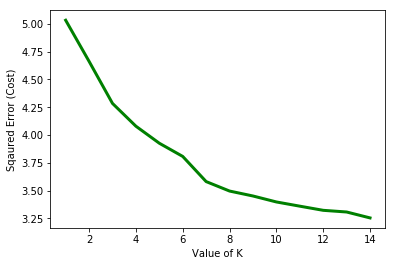

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt  
from matplotlib import style 
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs 

cost =[] 
city_grouped_clustering = city_grouped.drop('City', 1)

for i in range(1, 15): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(city_grouped_clustering) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 15), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show() # clear the plot 

While it is slightly difficult to determine where exactly the K bends, we will use "10" here. 

In [62]:
# set number of clusters
kclusters = 10

#city_grouped_clustering = city_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(city_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 5, 6, 1, 1, 6, 2, 1, 6, 6], dtype=int32)

In [63]:
# add clustering labels
city_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

city_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
city_merged = city_merged.join(city_venues_sorted.set_index('City'), on='City')

city_merged.head() # check the last columns!

,City,State,2018 estimate,2016 land area mile,2016 population density mi,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,New York,New York,8398748,301.5,28317,40.6635,-73.9387,6,Bar,Cocktail Bar,Pizza Place,Caribbean Restaurant,Park,Beer Bar,American Restaurant,New American Restaurant,Wine Shop,Coffee Shop
1,Los Angeles,California,3990456,468.7,8484,34.0194,-118.4108,4,Grocery Store,Coffee Shop,Japanese Restaurant,Café,Bakery,Taco Place,Pizza Place,Mexican Restaurant,Ice Cream Shop,New American Restaurant
2,Chicago,Illinois,2705994,227.3,11900,41.8376,-87.6818,2,Mexican Restaurant,Park,Bar,Coffee Shop,Taco Place,Diner,Pizza Place,Italian Restaurant,Art Gallery,Dessert Shop
3,Houston,Texas,2325502,637.5,3613,29.7866,-95.3909,6,Mexican Restaurant,Coffee Shop,Trail,Taco Place,American Restaurant,Yoga Studio,Brewery,Park,Grocery Store,Café
4,Phoenix,Arizona,1660272,517.6,3120,33.5722,-112.0901,2,Mexican Restaurant,Trail,Coffee Shop,Italian Restaurant,Burger Joint,Pizza Place,Convenience Store,Steakhouse,Fast Food Restaurant,Asian Restaurant


In [64]:
city_merged.shape

(314, 18)

In [65]:
#This is where I found some cities did not have any venue information because the latitude and longitude info was incorrect on the wikipedia page. 
# just running it again for the sanity purposes. 

df1 = city_merged[city_merged.isna().any(axis=1)]
df1

,City,State,2018 estimate,2016 land area mile,2016 population density mi,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue


Visualization of the resulting cluster

In [66]:

import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_merged['Latitude'], city_merged['Longitude'], city_merged['City'], city_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

So What is the lable of the city that I live in.

In [67]:
city_merged.loc[city_merged['City']=='San Mateo', ['Cluster Labels'] ]

,Cluster Labels
293,4


In [68]:
SanMateo=city_merged[city_merged['Cluster Labels']==4]
SanMateo

,City,State,2018 estimate,2016 land area mile,2016 population density mi,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Los Angeles,California,3990456,468.7,8484,34.0194,-118.4108,4,Grocery Store,Coffee Shop,Japanese Restaurant,Café,Bakery,Taco Place,Pizza Place,Mexican Restaurant,Ice Cream Shop,New American Restaurant
7,San Diego,California,1425976,325.2,4325,32.8153,-117.1350,4,Japanese Restaurant,Sushi Restaurant,Korean Restaurant,Mexican Restaurant,Sandwich Place,Ramen Restaurant,Noodle House,Bubble Tea Shop,Deli / Bodega,Seafood Restaurant
39,Miami,Florida,470914,36.0,12599,25.7752,-80.2086,4,Hotel,Seafood Restaurant,Italian Restaurant,Latin American Restaurant,American Restaurant,Cuban Restaurant,Argentinian Restaurant,Pizza Place,Smoke Shop,Asian Restaurant
40,Raleigh,North Carolina,469298,145.1,3163,35.8306,-78.6418,4,American Restaurant,Hotel,Spa,Mexican Restaurant,Italian Restaurant,Burger Joint,Shopping Mall,Toy / Game Store,Social Club,Japanese Restaurant
42,Long Beach,California,467354,50.3,9347,33.8092,-118.1553,4,Sushi Restaurant,Mexican Restaurant,Thai Restaurant,Diner,Burger Joint,American Restaurant,Coffee Shop,Café,Discount Store,Brewery
43,Virginia Beach,Virginia,450189,244.7,1850,36.7800,-76.0252,4,Supermarket,Park,Convenience Store,Brewery,Golf Course,Pizza Place,Seafood Restaurant,Mexican Restaurant,Breakfast Spot,Italian Restaurant
55,Honolulu,Hawaii,347397,60.5,5815,21.3243,-157.8476,4,Japanese Restaurant,Bakery,Chinese Restaurant,Coffee Shop,Hawaiian Restaurant,Gym,Diner,Noodle House,Seafood Restaurant,Café
66,Greensboro,North Carolina,294722,128.3,2237,36.0951,-79.8270,4,Coffee Shop,Steakhouse,Pizza Place,American Restaurant,Pet Store,Cosmetics Shop,Burger Joint,Sandwich Place,Garden,Italian Restaurant
70,Orlando,Florida,285713,105.2,2635,28.4166,-81.2736,4,Sandwich Place,Tex-Mex Restaurant,Gym / Fitness Center,Coffee Shop,Pizza Place,Hotel,Frozen Yogurt Shop,Italian Restaurant,Bakery,Snack Place
71,Irvine,California,282572,65.6,4057,33.6784,-117.7713,4,Park,Grocery Store,Burger Joint,Coffee Shop,Korean Restaurant,Dessert Shop,Chinese Restaurant,Frozen Yogurt Shop,Comedy Club,Sandwich Place


Let's see how many cities there are by SanMateo.shape.

In [69]:
SanMateo.shape

(56, 18)

Now let's merge the SanMateo data with the rent data based on the same city name. 

In [70]:
SanMateo_reloc = SanMateo

SanMateo_reloc = SanMateo_reloc.merge(rent.set_index('City'), on='City')
SanMateo_reloc

,City,State,2018 estimate,2016 land area mile,2016 population density mi,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,...,Year,Month,Price_Studio,Price_1br,Price_2br,Price_3br,Price_4br,Price_Change_MoM,Price_Change_YoY,ST
0,Los Angeles,California,3990456,468.7,8484,34.0194,-118.4108,4,Grocery Store,Coffee Shop,...,2019,11,1150,1369,1760,2391,2637,0.0,0.4,CA
1,San Diego,California,1425976,325.2,4325,32.8153,-117.1350,4,Japanese Restaurant,Sushi Restaurant,...,2019,11,1425,1578,2047,2948,3608,0.0,1.0,CA
2,Miami,Florida,470914,36.0,12599,25.7752,-80.2086,4,Hotel,Seafood Restaurant,...,2019,11,879,1087,1378,1897,2285,0.3,0.6,FL
3,Raleigh,North Carolina,469298,145.1,3163,35.8306,-78.6418,4,American Restaurant,Hotel,...,2019,11,817,1007,1164,1521,1859,-0.3,2.3,NC
4,Long Beach,California,467354,50.3,9347,33.8092,-118.1553,4,Sushi Restaurant,Mexican Restaurant,...,2019,11,1164,1386,1781,2420,2669,-0.2,1.0,CA
5,Virginia Beach,Virginia,450189,244.7,1850,36.7800,-76.0252,4,Supermarket,Park,...,2019,11,1084,1089,1311,1830,2283,0.1,1.8,VA
6,Greensboro,North Carolina,294722,128.3,2237,36.0951,-79.8270,4,Coffee Shop,Steakhouse,...,2019,11,669,750,886,1185,1404,0.0,2.5,NC
7,Orlando,Florida,285713,105.2,2635,28.4166,-81.2736,4,Sandwich Place,Tex-Mex Restaurant,...,2019,11,989,1081,1295,1723,2073,-0.3,1.8,FL
8,Newark,New Jersey,282090,24.1,11691,40.7242,-74.1726,4,Portuguese Restaurant,Brazilian Restaurant,...,2019,11,522,617,795,1022,1190,0.2,0.9,OH
9,Baton Rouge,Louisiana,221599,85.9,2651,30.4422,-91.1309,4,Grocery Store,Italian Restaurant,...,2019,11,632,773,895,1134,1422,-0.4,-1.7,LA


There are only 36 rows now which is becuase there wasn't overlapping data from the rent.
Looking at the SanMateo_reloc, I see some redundant data so I will drop some of the rows that I think irrelevant. 

In [71]:
SanMateo_reloc.drop([17,18],inplace=True)
SanMateo_reloc.reset_index(drop=True, inplace=True)
SanMateo_reloc

,City,State,2018 estimate,2016 land area mile,2016 population density mi,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,...,Year,Month,Price_Studio,Price_1br,Price_2br,Price_3br,Price_4br,Price_Change_MoM,Price_Change_YoY,ST
0,Los Angeles,California,3990456,468.7,8484,34.0194,-118.4108,4,Grocery Store,Coffee Shop,...,2019,11,1150,1369,1760,2391,2637,0.0,0.4,CA
1,San Diego,California,1425976,325.2,4325,32.8153,-117.1350,4,Japanese Restaurant,Sushi Restaurant,...,2019,11,1425,1578,2047,2948,3608,0.0,1.0,CA
2,Miami,Florida,470914,36.0,12599,25.7752,-80.2086,4,Hotel,Seafood Restaurant,...,2019,11,879,1087,1378,1897,2285,0.3,0.6,FL
3,Raleigh,North Carolina,469298,145.1,3163,35.8306,-78.6418,4,American Restaurant,Hotel,...,2019,11,817,1007,1164,1521,1859,-0.3,2.3,NC
4,Long Beach,California,467354,50.3,9347,33.8092,-118.1553,4,Sushi Restaurant,Mexican Restaurant,...,2019,11,1164,1386,1781,2420,2669,-0.2,1.0,CA
5,Virginia Beach,Virginia,450189,244.7,1850,36.7800,-76.0252,4,Supermarket,Park,...,2019,11,1084,1089,1311,1830,2283,0.1,1.8,VA
6,Greensboro,North Carolina,294722,128.3,2237,36.0951,-79.8270,4,Coffee Shop,Steakhouse,...,2019,11,669,750,886,1185,1404,0.0,2.5,NC
7,Orlando,Florida,285713,105.2,2635,28.4166,-81.2736,4,Sandwich Place,Tex-Mex Restaurant,...,2019,11,989,1081,1295,1723,2073,-0.3,1.8,FL
8,Newark,New Jersey,282090,24.1,11691,40.7242,-74.1726,4,Portuguese Restaurant,Brazilian Restaurant,...,2019,11,522,617,795,1022,1190,0.2,0.9,OH
9,Baton Rouge,Louisiana,221599,85.9,2651,30.4422,-91.1309,4,Grocery Store,Italian Restaurant,...,2019,11,632,773,895,1134,1422,-0.4,-1.7,LA


## Section 4. Result
----------------------

I can now sort the cities into depending on what kind of criteria I want to focus on.

Maybe I want to live in the cheapest city. 
Sorting the data with the "Price_3br" column since that's where our family is most interested in. 

In [72]:
SanMateo_reloc.sort_values(by=['Price_3br']).head()

,City,State,2018 estimate,2016 land area mile,2016 population density mi,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,...,Year,Month,Price_Studio,Price_1br,Price_2br,Price_3br,Price_4br,Price_Change_MoM,Price_Change_YoY,ST
8,Newark,New Jersey,282090,24.1,11691,40.7242,-74.1726,4,Portuguese Restaurant,Brazilian Restaurant,...,2019,11,522,617,795,1022,1190,0.2,0.9,OH
17,Peoria,Illinois,111388,48.2,2371,40.7515,-89.6174,4,Pizza Place,Coffee Shop,...,2019,11,557,641,822,1042,1194,-0.5,2.7,IL
10,Fayetteville,North Carolina,209468,147.7,1386,35.0828,-78.9735,4,Fast Food Restaurant,Department Store,...,2019,11,624,628,777,1081,1336,0.4,0.9,NC
18,Clarksville,Tennessee,156794,98.3,1529,36.5664,-87.3452,4,Bar,Fast Food Restaurant,...,2019,11,513,620,795,1089,1218,-0.1,3.4,TN
27,Evansville,Indiana,117963,47.3,2526,37.9877,-87.5347,4,Pizza Place,Italian Restaurant,...,2019,11,626,670,871,1090,1201,0.0,1.2,IN


Or maybe I want to live within California

In [73]:
SanMateo_reloc.loc[SanMateo_reloc['State']=='California']

,City,State,2018 estimate,2016 land area mile,2016 population density mi,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,...,Year,Month,Price_Studio,Price_1br,Price_2br,Price_3br,Price_4br,Price_Change_MoM,Price_Change_YoY,ST
0,Los Angeles,California,3990456,468.7,8484,34.0194,-118.4108,4,Grocery Store,Coffee Shop,...,2019,11,1150,1369,1760,2391,2637,0.0,0.4,CA
1,San Diego,California,1425976,325.2,4325,32.8153,-117.1350,4,Japanese Restaurant,Sushi Restaurant,...,2019,11,1425,1578,2047,2948,3608,0.0,1.0,CA
4,Long Beach,California,467354,50.3,9347,33.8092,-118.1553,4,Sushi Restaurant,Mexican Restaurant,...,2019,11,1164,1386,1781,2420,2669,-0.2,1.0,CA
21,Torrance,California,145182,20.5,7180,33.8350,-118.3414,4,Japanese Restaurant,Brewery,...,2019,11,1359,1617,2078,2825,3114,-0.3,0.1,CA
23,Santa Clara,California,129488,18.4,6845,37.3646,-121.9679,4,Korean Restaurant,Burger Joint,...,2019,11,1894,2226,2790,3873,4464,-0.6,0.3,CA
28,Carlsbad,California,115877,37.7,3023,33.1239,-117.2828,4,Theme Park,Hotel,...,2019,11,1747,1935,2510,3614,4423,1.5,2.1,CA
29,Costa Mesa,California,113615,15.7,7186,33.6659,-117.9123,4,Japanese Restaurant,Coffee Shop,...,2019,11,1537,1830,2351,3195,3523,0.2,-0.1,CA
36,San Mateo,California,105025,12.1,8592,37.5603,-122.3106,4,Japanese Restaurant,Grocery Store,...,2019,11,2873,3531,4436,5968,7097,-0.1,1.3,CA


Or maybe I like the cities with lots of people. San Mateo has a density of 8592 people/mile, so I'm going to find a city with larger than 8000. 

In [74]:
SanMateo_reloc.loc[SanMateo_reloc['2016 population density mi'] > 8000]

,City,State,2018 estimate,2016 land area mile,2016 population density mi,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,...,Year,Month,Price_Studio,Price_1br,Price_2br,Price_3br,Price_4br,Price_Change_MoM,Price_Change_YoY,ST
0,Los Angeles,California,3990456,468.7,8484,34.0194,-118.4108,4,Grocery Store,Coffee Shop,...,2019,11,1150,1369,1760,2391,2637,0.0,0.4,CA
2,Miami,Florida,470914,36.0,12599,25.7752,-80.2086,4,Hotel,Seafood Restaurant,...,2019,11,879,1087,1378,1897,2285,0.3,0.6,FL
4,Long Beach,California,467354,50.3,9347,33.8092,-118.1553,4,Sushi Restaurant,Mexican Restaurant,...,2019,11,1164,1386,1781,2420,2669,-0.2,1.0,CA
8,Newark,New Jersey,282090,24.1,11691,40.7242,-74.1726,4,Portuguese Restaurant,Brazilian Restaurant,...,2019,11,522,617,795,1022,1190,0.2,0.9,OH
24,Elizabeth,New Jersey,128885,12.3,10459,40.6664,-74.1935,4,Clothing Store,Department Store,...,2019,11,1062,1179,1405,1811,2017,-1.0,0.4,NJ
36,San Mateo,California,105025,12.1,8592,37.5603,-122.3106,4,Japanese Restaurant,Grocery Store,...,2019,11,2873,3531,4436,5968,7097,-0.1,1.3,CA


## Section 5. Discussion
--------------------------

Based on the Result section, Newark, NJ seems to have a low rent and similar population density to that of San Mateo, CA. 
Also, Los Angeles, CA is within California and also with a similar population density. 
Generally, cities within the current State of the residence (in which our case is California) seems to have a similar characteristic. 
Therefore, if we were to pick some candidate cities to relocate, the chances are we will select the cities from the SanMateo_reloc dataframe and learn more about the cities, which is definitely effective rather than clicking through random cities in the U.S.

In this report, K-means clustering was used. K-means clustering is relatively simple to implement and it generalizes to clusters of different shapes and sizes as shown in the map. However, K-means clustering has its limitation in having to choose the *k* manually which may not always be the optimal choice. Nonetheless, it is simple to understand and ideal in clustering a large number of cities as in the example in this report.  

## Section 6. Conclusions and Future Work
------------------

Relocation may happen for a lot of reasons. The job may require you to relocate and you would have to move to that specific city whether you like it or not. 
But sometimes, you might decided to relocate first and then find a new job from there. 
Often case it is extremely difficult to determine a city to relocate in a country where you do not have a sufficient knowledge. 

In this report, I used the list of populous cities in the U.S., location data from FourSquare API, and the latest median rent information to narrow down the list of cities to consider in relocating. 
From these data, I have clustered the cities with similar characteristic, specifically the similarities in the types of venues given a location of the city using the K-means clustering. 
Future work includes adding the information of cities not only in the U.S. but also in the other countries. 



## Appendix

This project is Week 4 and 5 assignment of Coursera's [Applied Data Science Capstone](https://www.coursera.org/learn/applied-data-science-capstone/)

The instruction for this assignment is as follows. 

> Be as creative as you want and come up with an idea to leverage the Foursquare location data to explore or compare neighborhoods or cities of your choice or to come up with a problem that you can use the Foursquare location data to solve. Make sure to provide sufficient justification of why you think what you want to do or solve is important and why would a client or a group of people be interested in your project.


![alt text](https://1.bp.blogspot.com/-abb3H5nTW7A/VXOT5Js2DeI/AAAAAAAAuE4/-D4TlMMPsX4/s600/machi_line2.png)